# Importing liberaries

In [1]:
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import set_random_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import tensorflow as tf

from sklearn.model_selection import train_test_split
from os import path, walk, listdir, makedirs
from os.path import exists
import shutil 
import cv2
import random


# Data Pre-Processing

In [2]:
# Define base directory paths for cats and dogs
cat_dir = r"G:\Portfolio Tech Demo\Deep Learning\2 Building Convolutional NN using Generators\cats"
dog_dir = r"G:\Portfolio Tech Demo\Deep Learning\2 Building Convolutional NN using Generators\dogs"

# Define parameters
random_state = 42
np.random.seed(random_state)
set_random_seed(random_state)
target_size = (120, 120)
batch_size = 100
test_ratio = 0.2
base_dir = path.dirname(cat_dir)

# Define Train and Validate Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    horizontal_flip=True,  # Randomly flip images horizontally
    rotation_range=20,          # Randomly rotate images by 20 degrees
    width_shift_range=0.1,      # Randomly shift width by 10%
    height_shift_range=0.1,     # Randomly shift height by 10%
    shear_range=0.2,            # Apply shearing transformation
    zoom_range=0.2,             # Randomly zoom into images by 20%
    brightness_range=[0.8, 1.2],# Randomly adjust brightness
    channel_shift_range=10      # Randomly shift color channels by up to 10
)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
# Create separate training and testing data (run only once)

#Create directory function
def create_directory(path):
  if not exists(path):
    makedirs(path)

# Copy files function
def copy_files(source_dir, dest_dir, ratio):
  files = listdir(source_dir)
  num_files = len(files)
  num_to_copy = int(num_files * ratio)
  selected_files = random.sample(files, num_to_copy)

  for file in selected_files:
    source_path = path.join(source_dir, file)
    dest_path = path.join(dest_dir, file)
    shutil.copy2(source_path, dest_path)

# Create model_data directory within the base directory
create_directory(path.join(base_dir, "model_data"))

# Create subdirectories inside model_data for test and train sets with cats and dogs folders
create_directory(path.join(base_dir, "model_data", "test", "cats"))
create_directory(path.join(base_dir, "model_data", "test", "dogs"))
create_directory(path.join(base_dir, "model_data", "train", "cats"))
create_directory(path.join(base_dir, "model_data", "train", "dogs"))

# Copy files to test directories
copy_files(cat_dir, path.join(base_dir, "model_data", "test", "cats"), test_ratio)
copy_files(dog_dir, path.join(base_dir, "model_data", "test", "dogs"), test_ratio)

# Copy remaining files to train directories
copy_files(cat_dir, path.join(base_dir, "model_data", "train", "cats"), 1 - test_ratio)
copy_files(dog_dir, path.join(base_dir, "model_data", "train", "dogs"), 1 - test_ratio)

print("Successfully created directories and copied files.")

Successfully created directories and copied files.


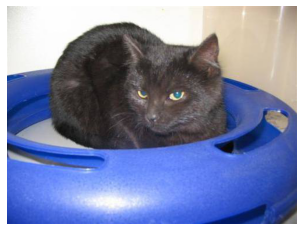

In [4]:
# Check random train cat images

train_cat_dir = path.join(base_dir, "model_data", "train", "cats")

# Get a list of all image filenames in the directory
all_filenames = [f for f in listdir(train_cat_dir) if f.lower().endswith((".jpg"))]

# Select a random image
random_index = random.randint(0, len(all_filenames) - 1)
chosen_image = all_filenames[random_index]

# Create the full image path
image_path = path.join(train_cat_dir, chosen_image)

# Read the image using OpenCV
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.axis('off')
plt.imshow(img)

In [5]:
# Create generators for training and validation data

train_dir_combined = path.join(base_dir, "model_data", "train")
validation_dir_combined = path.join(base_dir, "model_data", "test")

train_generator = train_datagen.flow_from_directory(
    train_dir_combined,
    target_size= target_size,
    batch_size= batch_size,
    class_mode= 'binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir_combined,
    target_size= target_size,
    batch_size=batch_size,
    class_mode='binary'
)

print(train_generator.class_indices)
print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {validation_generator.samples}")

# Check if the generators are initialized properly
if train_generator.samples == 0 or validation_generator.samples == 0:
    raise ValueError("One of the generators has no samples. Please check the paths and directories.")

# Wrap the generators in a TensorFlow dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, target_size[0], target_size[1], 3], [None])
).repeat()

validation_dataset = tf.data.Dataset.from_generator(
    lambda: validation_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, target_size[0], target_size[1], 3], [None])
).repeat()



Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}
Number of training samples: 1600
Number of validation samples: 400


# Model Building

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
train_generator: <keras_preprocessing.image.directory_iterator.DirectoryIterator object at 0x0000017B2A159B70>
validation_generator: <keras_preprocessing.image.directory_iterator.DirectoryIterator object at 0x0000017B2A159BA8>
Train on 16 steps, validate on 4 steps
Epoch 1/200
16/16 [==============================] - 18s 1s/step - loss: 0.7443 - acc: 0.4994 - val_loss: 0.6898 - val_acc: 0.5000
Epoch 2/200
16/16 [==============================] - 8s 482ms/step - loss: 0.7066 - acc: 0.5156 - val_loss: 0.6890 - val_acc: 0.5700
Epoch 3/200
16/16 [==============================] - 8s 484ms/step - loss: 0.6838 - acc: 0.5675 - val_loss: 0.6912 - val_acc: 0.5275
Epoch 4/200
16/16 [==============================] - 8s 475ms/step - loss: 0.7024 - acc: 0.5219 - val_loss: 0.6926 - val_acc: 0.5000
Epoch 5/200
16/16 [==========

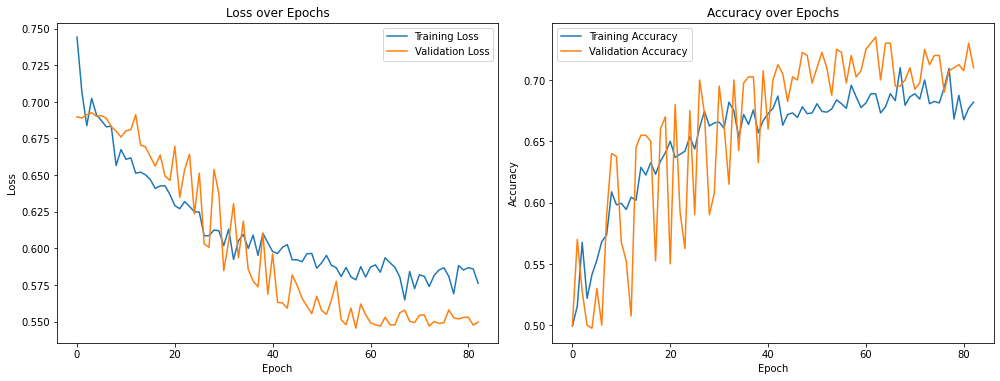

In [6]:
epochs = 200

# Define the CNN model
def create_model():
  # Input layer with the expected image dimensions
  inputs = Input(shape=(target_size[0], target_size[1], 3))

  x = Conv2D(5, (3,3), padding = "valid", activation='relu')(inputs)  
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Conv2D(10, (3,3), padding = "valid", activation='relu')(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  x = Flatten()(x)
  x = Dense(100, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(50, activation='relu')(x)
  x = BatchNormalization()(x)

  # Output layer for binary classification
  outputs = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=inputs, outputs=outputs)

  model.compile(loss="binary_crossentropy", 
                optimizer= SGD(), 
                metrics=["accuracy"])

  return model

# Train the model
model = create_model()

# Define early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_acc', patience=20, restore_best_weights=True)

# Calculate steps_per_epoch and validation_steps
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

# Modify steps_per_epoch and validation_steps for datasets
steps_per_epoch_dataset = train_generator.samples // batch_size
validation_steps_dataset = validation_generator.samples // batch_size

# If the number of samples is not perfectly divisible by the batch size, add one step
if train_generator.samples % batch_size != 0:
    steps_per_epoch_dataset += 1
if validation_generator.samples % batch_size != 0:
    validation_steps_dataset += 1

# Learning rate schedule function
def learning_rate_schedule(epoch):
  # Initial learning rate
  initial_lr = 0.2
  # Decrease factor after every n epochs
  decay_factor = 0.5
  # Decay every n epochs
  decay_step = 10

  lr = initial_lr * (decay_factor**(epoch // decay_step))
  return lr

learning_rate_scheduler_callback = LearningRateScheduler(learning_rate_schedule)

print(f"train_generator: {train_generator}")
print(f"validation_generator: {validation_generator}")

history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch_dataset,
    validation_data=validation_dataset,
    validation_steps=validation_steps_dataset,
    epochs=epochs,
    callbacks=[learning_rate_scheduler_callback, early_stopping_callback]
)
  
# Extract training and validation history from the training process
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']
accuracy_history = history.history['acc']
val_accuracy_history = history.history['val_acc']

# Plot the results
plt.figure(figsize=(14, 10))

# Plot loss
plt.subplot(2, 2, 1)
plt.plot(range(len(loss_history)), loss_history, label='Training Loss')
plt.plot(range(len(val_loss_history)), val_loss_history, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(2, 2, 2)
plt.plot(range(len(accuracy_history)), accuracy_history, label='Training Accuracy')
plt.plot(range(len(val_accuracy_history)), val_accuracy_history, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



In [7]:
model.summary()  # Print model summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 118, 118, 5)       140       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 5)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 10)        460       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7840)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               784100

In [8]:
# Saving the model
model.save('Cat_or_Dog_model.h5')

# Testing Model

In [9]:
# Load the saved model
loaded_model = load_model(r"G:\Portfolio Tech Demo\Deep Learning\2 Building Convolutional NN using Generators\Cat_or_Dog_model.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


[[0.39626536]]
Predicted Class Label: Cat


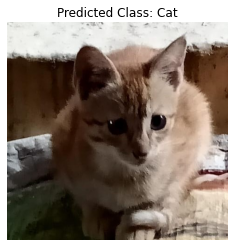

In [10]:
# Load and preprocess the new image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(120,120))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array


new_image_path = r"G:\Portfolio Tech Demo\Deep Learning\2 Building Convolutional NN using Generators\Image\test image.jpeg"
img_array = load_and_preprocess_image(new_image_path)

# Make predictions using the model
preds = loaded_model.predict(img_array)
print(preds)

# Interpret the predictions
classes = ["Cat", "Dog"]
preds_class_index = 1 if preds[0][0] > 0.5 else 0
preds_class_label = classes[preds_class_index]
print(f"Predicted Class Label: {preds_class_label}")

# Display the image
img_display = cv2.imread(new_image_path)
img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)
plt.imshow(img_display)
plt.title(f"Predicted Class: {preds_class_label}")
plt.axis('off')
plt.show()